<a href="https://colab.research.google.com/github/jvschw/fmriGAN/blob/main/jens_img_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Setup**

# REQUIREMENTS TO RUN THIS NOTEBOOK

*   You need to be in the directory that contains 'model_wgan_gp.py' and 'utils_wgan_gp.py'
*   You need the ./tstat_0mm/handleft/sub100307.nii.gz
*   You need the t_of_t.nii.gz file
*   You need the model checkpoints in a directory called 'checkpoint_models'



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

!pip install nltools
!pip install nilearn

%cd "/content/gdrive/MyDrive/Masterarbeit"
%pylab inline

import scipy
import numpy as np
import os
import nibabel as nib
import datetime
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.data.dataset import Dataset
from nilearn import plotting
from scipy.ndimage import zoom
from nltools.data import Brain_Data
from torch.nn import functional as F
from torch import autograd
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from utils_wgan_gp import gradient_penalty, save_checkpoint, load_checkpoint

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/gdrive
     |████████████████████████████████| 3.3 MB 7.1 MB/s 
     |████████████████████████████████| 10.0 MB 71.6 MB/s 
/content/gdrive/MyDrive/Masterarbeit
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# FUNCTIONS

In [2]:
def saveResampledNifti(generatedData64, imgREF, fNameOut):
    dims = imgREF.shape
    generatedDataOrgRes = zoom(generatedData64, (dims[0]/64, dims[1]/64, dims[2]/64))
    imgRes = nib.Nifti1Image(generatedDataOrgRes, affine = imgREF.affine)
    nib.save(imgRes, fNameOut)

In [3]:
# MAY WANT TO ADD A RANDOM GENERATOR SEED FOR REPRODUCIBILITY HERE
def generate_fake(generator, z_dim, output_dir, n_fakes=100, batch_size=1):
  from tqdm.notebook import tqdm  # a nice waitbar for notebooks

  print('saving into %s' % output_dir)
  for k in tqdm(range(n_fakes)):

      noise = torch.randn(batch_size, z_dim, 1, 1, 1).to(device)
      dat = generator(noise)

      fNameOut = os.path.join(output_dir,'fake'+'{:03}'.format(k+1) + '.nii.gz')
      generatedData64 = np.squeeze(dat.data.cpu().numpy())
      saveResampledNifti(generatedData64, imgREF, fNameOut)

# Loading

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
CHANNELS_IMG = 1
Z_DIM = 1000
FEATURES_GEN = 32
BATCH_SIZE = 4
ITER = 100

from model_wgan_gp_tanh import Discriminator, Generator, initialize_weights

In [5]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)

# adapt this name for one of the checkpoints in "checkpoint_models"
model_name = 'b%d_z%d_gen_iter%06d' %(BATCH_SIZE, Z_DIM, ITER)  
#gen.load_state_dict(torch.load("checkpoint_models/%s.pth" % model_name))

### for loading in a further special folder
model_name = "ckpt_gen_iter000100"
gen.load_state_dict(torch.load("checkpoint_models/footright_tanh/%s.pth" % model_name))

<All keys matched successfully>

# calculate chi-quadrat

In [6]:
noise = torch.randn(100, Z_DIM, 1, 1, 1).to(device)
run = gen(noise).detach().cpu().numpy()
avg_fake = np.sum(run,axis=0).squeeze()/100 #.shape

In [7]:
PATH_TO_DATA="/content/gdrive/MyDrive/Masterarbeit/tstat_0mm"

class RealDataset(Dataset):

    def __init__(self, data_dir, labels, n, transforms=None):
        self.transforms = transforms
        self.mask = np.load("mask_dil64.npy")
        # get the files
        for iLabel in range(len(labels)):
            file_names = sorted(glob.glob(os.path.join(data_dir, labels[iLabel], "*.nii.gz")))

            if iLabel == 0:
                self.data = np.array(file_names[:n])
                self.labels = np.array(np.repeat(labels[iLabel], len(self.data)))
            else:
                self.data = np.append(self.data, file_names[:n])
                self.labels = np.append(self.labels, np.repeat(labels[iLabel], len(self.data)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        img = np.nan_to_num(nib.load(self.data[idx]).get_fdata())  
        img[np.isnan(img)] = 0

        dims = img.shape
        img_ = zoom(img, (64/dims[0], 64/dims[1], 64/dims[2]))

        img_ = (img_-np.min(img_))/(np.max(img_)-np.min(img_))
        img_ = 2*img_-1

        mask_img = img_ * self.mask

        mask_img = torch.tensor(mask_img)
        mask_img = mask_img.unsqueeze(0)
        


        sample = {'img': mask_img.float(), 'label': self.labels[idx]}
        return sample

In [8]:
dataset = RealDataset(PATH_TO_DATA, ["footright"], 100) 

In [51]:
loader = torch.utils.data.DataLoader(dataset,batch_size=100, shuffle=False, num_workers=0, drop_last=True)

In [52]:
for batch_idx, real in enumerate(loader):
    real = real["img"].detach().cpu().numpy()


In [11]:
avg_real = np.sum(real,axis=0).squeeze()/100 

In [12]:
real.flatten().shape

(26214400,)

In [ ]:
hist(real.flatten(),50)

In [ ]:
noise = torch.randn(100, Z_DIM, 1, 1,1).to(device)
fake_image = gen(noise)

hist(fake_image.detach().cpu().numpy().flatten(),50)

### compare generation quality with mse

In [ ]:
def mse_comp(imgA, imgB):
	# sum of the squared difference between the two images;
	err = np.sum((imgA - imgB) ** 2)
	err /= (imgA.shape[0] * imgA.shape[1] * imgA.shape[2])
	# return the MSE, the lower the error, the more "similar" the two images are
	return err

print("mse for current activation function:",mse_comp(avg_real,avg_fake))

print("ReLU:","0.00121")
print("leaky Relu:", "0.00042")
print("Tanh:","0.0001809" )

### compare generation quality with ssim 

In [16]:
from skimage.metrics import structural_similarity as ssim
ssim_const = ssim(avg_real, avg_fake,data_range=avg_fake.max() - avg_fake.min())


print("ssim for current activation function:",ssim_const)

print("ssim ReLU:","0.7655")
print("ssim leaky Relu:","0.8673")
print("ssim Tanh:","0.8866"  )
print("ssim ReLU after training for 1 epoch:","0.1210"  )
print("ssim Tanh 200 epochs:","0.84023"  )
print("ssim Tanh footright:","0.78")

ssim for current activation function: 0.7638824939036809
ssim ReLU: 0.7655
ssim leaky Relu: 0.8673
ssim Tanh: 0.8866
ssim ReLU after training for 1 epoch: 0.1210
ssim Tanh 200 epochs: 0.84023
ssim Tanh footright: 0.78


### compare generation quality with ssim (different approach)

In [ ]:
"""
loader = torch.utils.data.DataLoader(dataset,batch_size=100, shuffle=True, num_workers=0, drop_last=True)

for batch_idx, real in enumerate(loader):
    real_ten = real["img"]

import pytorch_ssim
import torch
from torch.autograd import Variable

img1 = real_ten
img2 = gen(noise)

if torch.cuda.is_available():
    img1 = img1.cuda()
    img2 = img2.cuda()

print("ssim3D:",ssim3D(img1, img2))
"""

### for comparing 1 real with 1 fake example

In [54]:
for batch_idx, real in enumerate(loader):
    if batch_idx == 0:
        real_ = real["img"]
        
noise = torch.randn(100, Z_DIM, 1, 1, 1).to(device)
generated = gen(noise)

In [19]:
real_one = real_[0].flatten(start_dim=0,end_dim=1).detach().cpu().numpy()
real_two = real_[1].flatten(start_dim=0,end_dim=1).detach().cpu().numpy()
real_three = real_[2].flatten(start_dim=0,end_dim=1).detach().cpu().numpy()
real_four = real_[3].flatten(start_dim=0,end_dim=1).detach().cpu().numpy()


fake_one  = generated[0].flatten(start_dim=0,end_dim=1).detach().cpu().numpy()
fake_two  = generated[1].flatten(start_dim=0,end_dim=1).detach().cpu().numpy()
fake_three  = generated[2].flatten(start_dim=0,end_dim=1).detach().cpu().numpy()
fake_four  = generated[3].flatten(start_dim=0,end_dim=1).detach().cpu().numpy()

In [20]:
from skimage.metrics import structural_similarity as ssim

re_list = [real_one,real_two,real_three,real_four]
fa_list = [fake_one,fake_two, fake_three,fake_four]

sum_ssim = 0
for x,re in enumerate(re_list):
    for y, fa in enumerate(fa_list):
        ssim_ = ssim(re, fa,data_range=fa.max() - fa.min())
        print("ssim", ssim_, x, y )
        sum_ssim += ssim_

print(sum_ssim/16)



#print("ssim for current activation function:",ssim_const)

ssim 0.49901114475339575 0 0
ssim 0.6999344030249389 0 1
ssim 0.47275524740928543 0 2
ssim 0.3726712366894662 0 3
ssim 0.4719856809533139 1 0
ssim 0.7093735627322614 1 1
ssim 0.44140387772843975 1 2
ssim 0.3414898261462919 1 3
ssim 0.3730034924555408 2 0
ssim 0.4442427660801297 2 1
ssim 0.37827433170569785 2 2
ssim 0.48404398212753397 2 3
ssim 0.4833419043211752 3 0
ssim 0.687407405104397 3 1
ssim 0.45605812086692177 3 2
ssim 0.3537405029106016 3 3
0.47929609281308694


### ssim for all el individually

In [21]:
real_list = [real_[i].flatten(start_dim=0,end_dim=1).detach().cpu().numpy() for i in range(100)]
fake_list = [generated[i].flatten(start_dim=0,end_dim=1).detach().cpu().numpy() for i in range(1)]


sum_ssim = 0
for x,re in enumerate(real_list):
    for y, fa in enumerate(fake_list):
        ssim_ = ssim(re, fa,data_range=fa.max() - fa.min())
        sum_ssim += ssim_

print(sum_ssim/10000)

0.004171600674355553


In [22]:
print("real_list vs fake_list:",0.1991)
print("real_list vs real_list:", 0.5134)
print("fake_list vs fake_list:",0.3892 )

real_list vs fake_list: 0.1991
real_list vs real_list: 0.5134
fake_list vs fake_list: 0.3892


In [ ]:
ssim_matrix = np.zeros((100,100))
sum_ssim = 0
real_list = [real_[i].flatten(start_dim=0,end_dim=1).detach().cpu().numpy() for i in range(100)]

for i in range(100):
    noise = torch.randn(1, Z_DIM, 1, 1, 1).to(device)
    generated = gen(noise)
    fa = generated[0].flatten(start_dim=0,end_dim=1).detach().cpu().numpy() 

    for y, re in enumerate(real_list):
        ssim_ = ssim(re, fa,data_range=fa.max() - fa.min())
        ssim_matrix[i,y] = ssim_
        #sum_ssim += ssim_

#print(sum_ssim/100/100)
plt.imshow(ssim_matrix)

In [ ]:
## maybe sort after ssim value of cols -> avg of rows

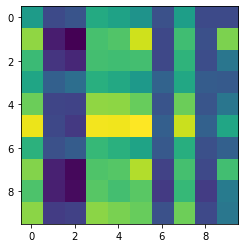

In [65]:
ssim_matrix = np.zeros((10,10))
sum_ssim = 0
real_list = [real_[i].flatten(start_dim=0,end_dim=1).detach().cpu().numpy() for i in range(10)]

for i in range(10):
    noise = torch.randn(1, Z_DIM, 1, 1, 1).to(device)
    generated = gen(noise)
    fa = generated[0].flatten(start_dim=0,end_dim=1).detach().cpu().numpy() 

    for y, re in enumerate(real_list):
        ssim_ = ssim(re, fa,data_range=fa.max() - fa.min())
        ssim_matrix[i,y] = ssim_
        #sum_ssim += ssim_

#print(sum_ssim/100/100)
plt.imshow(ssim_matrix)

In [ ]:
plt.imshow(ssim_matrix,cmap=True)

In [62]:
noise = torch.randn(1, Z_DIM, 1, 1, 1).to(device)
generated = gen(noise)
fa = generated[0].flatten(start_dim=0,end_dim=1).detach().cpu().numpy() 

print( ssim(real_list[0], fa,data_range=fa.max() - fa.min()) )
print( ssim(fa, real_list[0],data_range=fa.max() - fa.min()) ) 


0.5667515176339595
0.5667515176339595


In [48]:
#imgRes = nib.Nifti1Image(real_list[7], affine = imgREF.affine)
#nib.save(imgRes, "junk.nii.gz")

saveResampledNifti(real_list[7],imgREF,"junk2.nii.gz")

In [47]:
real_list[7].shape

(64, 64, 64)

In [24]:
print("footright: real_list vs 1 fake , 100 times -> average:",0.430)
print("handleft: real_list vs 1 fake , 100 times -> average:",0.468)

footright: real_list vs 1 fake , 100 times -> average: 0.43
handleft: real_list vs 1 fake , 100 times -> average: 0.468


# visualize data


In [25]:
noise = torch.randn(100, Z_DIM, 1, 1,1).to(device)
fake_image = gen(noise)

In [26]:
avg_200 = torch.mean(fake_image,axis=0).flatten(start_dim=0,end_dim=1)

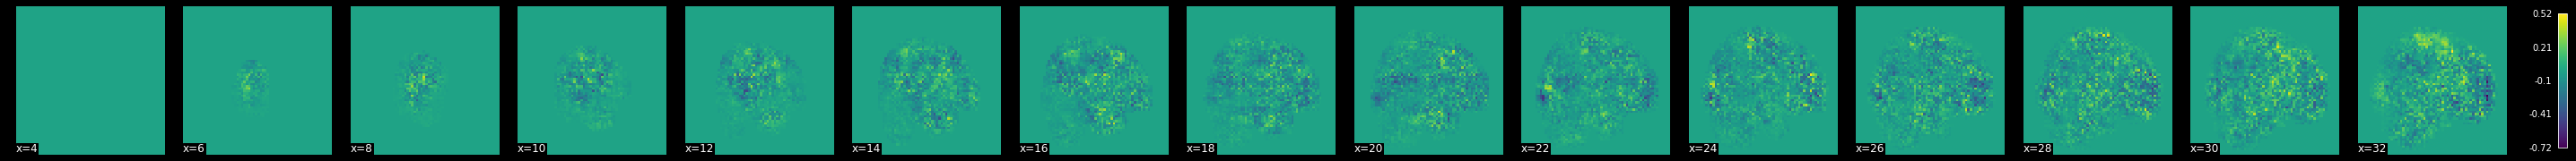

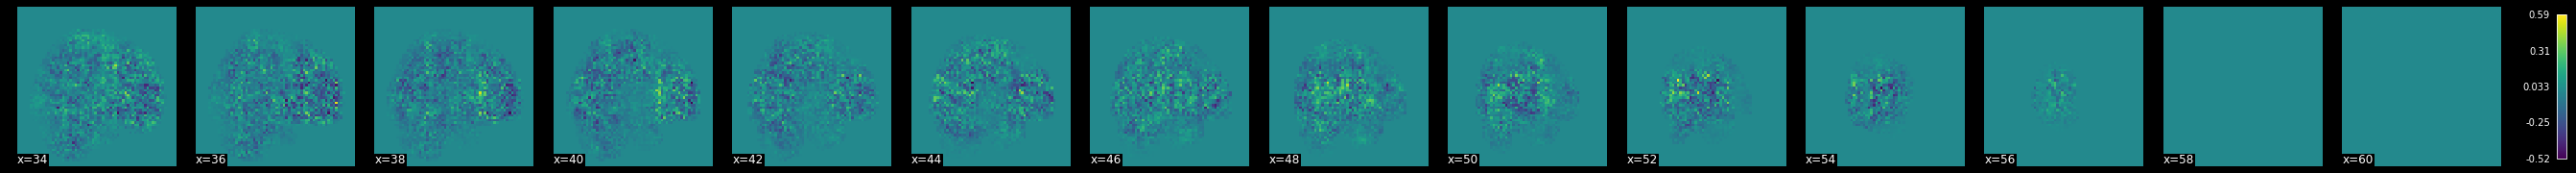

In [27]:
file_mask =  np.load("mask_dil64.npy")

noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1,1).to(device)
fake_image = gen(noise) 


featmask_ = np.squeeze(fake_image[0].data.cpu().numpy() ) * file_mask 
featmask = nib.Nifti1Image(featmask_,affine = np.eye(4))

arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]

disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,colorbar=True,annotate=True,black_bg=True,display_mode='x')
plotting.show()
disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,colorbar=True,annotate=True,black_bg=True,display_mode='x')
plotting.show()


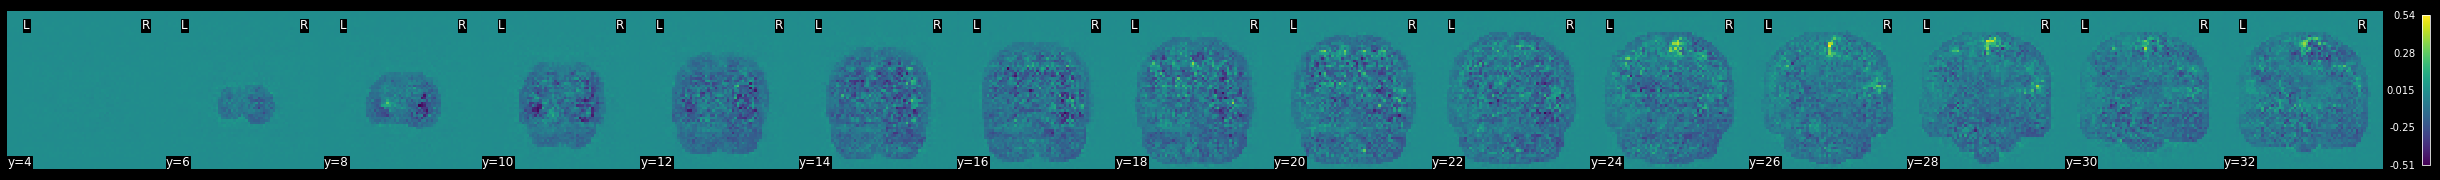

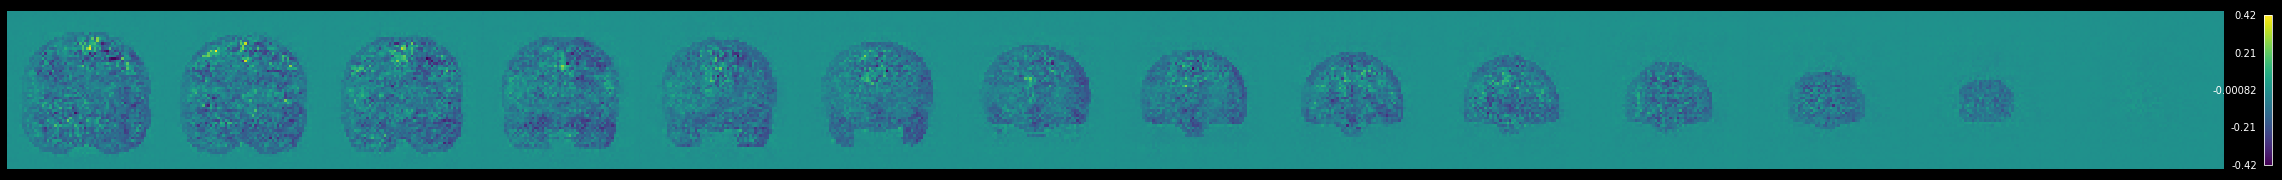

In [28]:
noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1,1).to(device)
fake_image = gen(noise)
featmask_ = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask_,affine = np.eye(4))

arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]

disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,colorbar=True,annotate=True,black_bg=True,display_mode='y')
plotting.show()
disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,colorbar=True,annotate=False,black_bg=True,display_mode='y')
plotting.show()

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00,
        1.00000e+00, 1.00000e+00, 3.00000e+00, 3.00000e+00, 4.00000e+00,
        7.00000e+00, 8.00000e+00, 1.00000e+01, 1.70000e+01, 2.20000e+01,
        2.60000e+01, 2.80000e+01, 2.50000e+01, 4.90000e+01, 4.90000e+01,
        5.90000e+01, 1.02000e+02, 1.30000e+02, 1.46000e+02, 1.77000e+02,
        1.96000e+02, 2.96000e+02, 3.92000e+02, 5.00000e+02, 6.11000e+02,
        8.53000e+02, 1.07500e+03, 1.27500e+03, 1.54800e+03, 1.90600e+03,
        2.27000e+03, 2.81200e+03, 3.29000e+03, 3.75300e+03, 4.19500e+03,
        4.61200e+03, 4.97000e+03, 5.02900e+03, 5.24300e+03, 5.23400e+03,
        4.87600e+03, 4.70400e+03, 4.33400e+03, 4.11800e+03, 4.75600e+03,
        1.71880e+04, 1.36465e+05, 2.53150e+04, 3.37500e+03, 1.64000e+03,
        9.59000e+02, 7.62000e+02, 5.81000e+02, 4.29000e+02, 3.37000e+02,
        2.37000e+02, 2.20000e+02, 1.80000e+02, 1.19000e+02, 1.30000e+02,
        7.80000e+01, 6.80000e+01, 6.40000e+01, 4.00

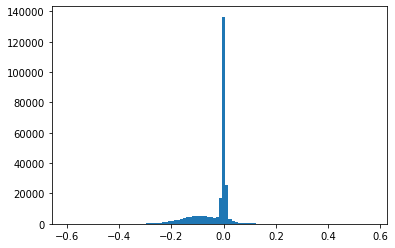

In [29]:
hist(featmask.get_fdata().flatten(),100)

In [30]:
#hist(featmask_.flatten(),100)

In [31]:
#test = Brain_Data("checkpoint_images/ckpt_gen_iter000100/fake001.nii.gz")
#test.iplot()

In [45]:
PROJECT_DIR = "."

PATH_CHECKPOINT_IMG = os.path.join(PROJECT_DIR, 'checkpoint_images', model_name)
if not os.path.exists(PATH_CHECKPOINT_IMG):
  os.mkdir(PATH_CHECKPOINT_IMG)

imgREF = nib.load(os.path.join(PROJECT_DIR, 'tstat_' + '0mm', ['handleft'][0], 'sub100307.nii.gz'))

# Generate fake data

In [ ]:
generate_fake(gen, Z_DIM, PATH_CHECKPOINT_IMG, n_fakes=100, batch_size=1)

# Compute t-scores
## Load fake data with Brain_Data

In [33]:
files = glob.glob("/content/gdrive/MyDrive/Masterarbeit/checkpoint_images/"+ model_name  + '/fake*.nii.gz')
fakes = Brain_Data(files)

In [34]:
fakes[0].iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

In [35]:
# show histogram of values for first sample
#a = plt.hist(fakes.data[0], bins=1000)

In [36]:
# perform a ttest agains 0
fake_stats = fakes.ttest()
#fake_stats["t"].write(os.path.join(PATH_CHECKPOINT_IMG, 'tmap.nii.gz'))

In [37]:
# compute the Bonferroni corrected critical t-score
n_samples, n_voxels = fakes.data.shape
crit_t = scipy.stats.t.ppf(1-(0.05/n_voxels), n_samples-1)

In [38]:
"""
#check if a there is a inf value amont the t-values
print(np.where(fake_stats['t'].data == float("inf") ) )

inf_list = []

for i in range(100):
  inf_list.append(fakes[i].data[143262])

inf_list

fake_stats['t'].data[143262]

std = np.std(inf_list)
print("std error:",std/sqrt(100))
print("mean:",np.mean(inf_list))
"""

'\n#check if a there is a inf value amont the t-values\nprint(np.where(fake_stats[\'t\'].data == float("inf") ) )\n\ninf_list = []\n\nfor i in range(100):\n  inf_list.append(fakes[i].data[143262])\n\ninf_list\n\nfake_stats[\'t\'].data[143262]\n\nstd = np.std(inf_list)\nprint("std error:",std/sqrt(100))\nprint("mean:",np.mean(inf_list))\n'

Text(0, 0.5, 'frequency')

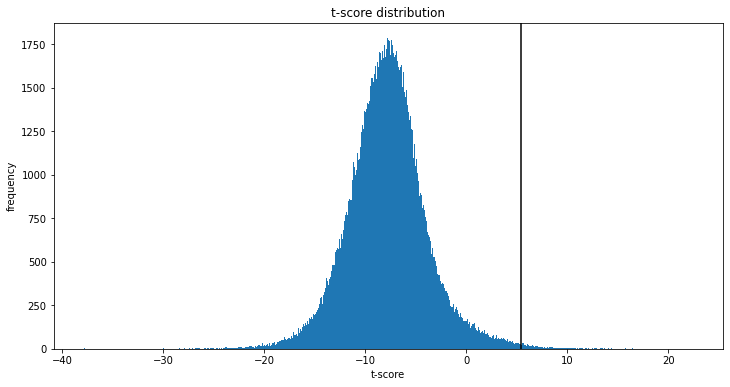

In [39]:
# show a distribution of the t-scroes; those to the right of the black vertical
# line are Bonferroni significant
fig = plt.figure(figsize=(12,6))
a = plt.hist(fake_stats['t'].data, bins=1000)
b = plt.axvline(x=crit_t, color='black')
plt.title('t-score distribution')
plt.xlabel('t-score')
plt.ylabel('frequency')

In [40]:
# plot the t-map. Use the critical t-score as threshold

file_mask = Brain_Data("MNI152_T1_2mm_brain_mask.nii.gz")

masked_fake_stats = fake_stats['t'] * file_mask
masked_fake_stats.iplot(threshold=crit_t)

interactive(children=(FloatText(value=5.4210929642374825, description='Threshold'), HTML(value='Image is 3D', …

In [ ]:
# plot the t-map. Use the critical t-score as threshold

file_mask = Brain_Data("MNI152_T1_2mm_brain_mask.nii.gz")

masked_fake_stats = fake_stats['t'] * file_mask
masked_fake_stats.iplot(threshold=crit_t)

interactive(children=(FloatText(value=5.4210929642374825, description='Threshold'), HTML(value='Image is 3D', …

In [ ]:
rho = t_real.similarity(fakes, method='correlation') 
print("mean correlation:",mean(rho))

# IMPORTANT 3D SSIM

In [ ]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def create_window_3D(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t())
    _3D_window = _1D_window.mm(_2D_window.reshape(1, -1)).reshape(window_size, window_size, window_size).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_3D_window.expand(channel, 1, window_size, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)
    
def _ssim_3D(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv3d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv3d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)

    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv3d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv3d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv3d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)
    


class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)
    
    
class SSIM3D(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM3D, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window_3D(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window_3D(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim_3D(img1, img2, window, self.window_size, channel, self.size_average)

    
def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

def ssim3D(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _, _) = img1.size()
    window = create_window_3D(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim_3D(img1, img2, window, window_size, channel, size_average)